In [1]:
LABELED_REGIONS_VERSION = 4

CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

DELETION_SIZE_THRESHOLD = 1000000

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

BALANCE_CLASSES = False

In [2]:
import numpy as np 
import pandas as pd 
from shell import shell 

def collapse(ser): 
  unique_value, = set(ser)
  return unique_value

def count(ser): 
  if len(ser) == 1 and ser.iloc[0] == '.': return 0
  return len(ser) 

def custom_max(ser): 
  if len(ser) == 1 and ser.iloc[0] == '.': return '.'
  return np.max([int(value) for value in list(ser)])

def custom_list(ser): 
  if len(ser) == 1 and ser.iloc[0] == '.': return '.'
  return list(ser)

def aggregate_over_deletions(df, group_columns, aggregation_functions): 
  groups = df.groupby(group_columns)
  aggregated = groups.agg(aggregation_functions)  
  df = aggregated.reset_index()
  df.columns = [' '.join(col[::-1]).strip() for col in df.columns.values]
  return df

def read_labeled_regions_intersect_deletions():
  cmd = f'bash {CONSTRAINT_TOOLS}/experiments/germline-model/chen-et-al-2022/intersect-labeled-regions-{LABELED_REGIONS_VERSION}-with-sizeFiltered-topmed-deletions.sh {LABELED_REGIONS_VERSION} {DELETION_SIZE_THRESHOLD}'
  print(shell(cmd))
  df = pd.read_csv(
    f"{CONSTRAINT_TOOLS_DATA}/khurana/labeled-regions-{LABELED_REGIONS_VERSION}-intersect-sizeFiltered-topmed-deletions.bed", 
    sep = '\t',
  )  
  group_columns = [
    'chrom',
    'start',
    'end',
    'truly constrained',
    'tag',
    'min negative_new_chen_score_window',
    'count negative_new_chen_score_window',
    'region_id'
  ]
  aggregation_functions = {
    'SVLEN': [custom_max],
    'SVTYPE': [collapse, count],
    'SV_ID': [custom_list],
    'Het': [custom_max],
    'HomAlt': [custom_max],
    'region-deletion-overlap': [custom_max]
  }
  aggregation_columns = list(aggregation_functions.keys())
  new_columns = group_columns + aggregation_columns
  df = df[new_columns]
  df = aggregate_over_deletions(df, group_columns, aggregation_functions)
  df = df.rename(columns={
    'chrom': 'chrom_region',
    'start': 'start_region',
    'end': 'end_region',
  })
  df['region is deleted in topmed'] = df['collapse SVTYPE'] == 'DEL'
  print('number of regions that are deleted in TopMed (True) or not (False):')
  print(df['region is deleted in topmed'].value_counts())
  print(df['count SVTYPE'].value_counts())
  print(df['custom_max region-deletion-overlap'].value_counts())
  
  positive_examples = df[df['truly constrained'] == True]

  negative_examples = df[df['truly constrained'] == False]
  if BALANCE_CLASSES:
    negative_examples = negative_examples.sample(n=len(positive_examples), random_state=0) # balance classes for later training 

  df = pd.concat([negative_examples, positive_examples])
  return df 

pd.set_option('display.max_rows', 1000)

LABELED_EXAMPLES = read_labeled_regions_intersect_deletions()
LABELED_EXAMPLES.head()

Wrote labeled regions with intersecting size-filtered topmed deletions to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/khurana/labeled-regions-4-intersect-sizeFiltered-topmed-deletions.bed

number of regions that are deleted in TopMed (True) or not (False):
True     747
False    371
Name: region is deleted in topmed, dtype: int64
0      371
1      316
2      167
3       91
4       53
5       32
7       20
6       15
9       10
8        8
10       7
13       6
15       3
14       2
11       2
21       2
17       2
18       2
26       1
19       1
254      1
49       1
95       1
20       1
33       1
70       1
12       1
Name: count SVTYPE, dtype: int64
1000    700
0       371
2000      7
2400      6
1800      6
1400      5
600       5
1600      5
200       4
800       3
1200      3
2200      2
400       1
Name: custom_max region-deletion-overlap, dtype: int64


,chrom_region,start_region,end_region,truly constrained,tag,min negative_new_chen_score_window,count negative_new_chen_score_window,region_id,custom_max SVLEN,collapse SVTYPE,count SVTYPE,custom_list SV_ID,custom_max Het,custom_max HomAlt,custom_max region-deletion-overlap,region is deleted in topmed
0,chr1,17253000,17254000,False,random_noncoding_nonenhancer,-1.995430,1,180,22338,DEL,1,[DEL_1:17236517-17258854],1,0,1000,True
1,chr1,19832000,19833000,False,random_noncoding_nonenhancer,-0.454322,1,723,660857,DEL,1,[DEL_1:19751232-20412088],1,0,1000,True
2,chr1,20541000,20542000,False,random_noncoding_nonenhancer,-1.825657,1,819,6592,DEL,1,[DEL_1:20539142-20545733],6,0,1000,True
4,chr1,31722000,31723000,False,random_noncoding_nonenhancer,-1.271066,1,783,501200,DEL,2,"[DEL_1:31719848-31724753, DEL_1:31235267-31736...",2,0,1000,True
5,chr1,35103000,35104000,False,random_noncoding_nonenhancer,0.065322,1,910,.,.,0,.,.,.,0,False


## SNV-only, SV-only, and SNV+SV classifiers 

In [3]:
def predict_constraint_using_SNVs(df, zscore_threshold): 
  score = 'min negative_new_chen_score_window'
  df = df[[score, 'truly constrained']].copy()
  df['predicted to be constrained'] = df[score] < zscore_threshold
  return df

predict_constraint_using_SNVs(LABELED_EXAMPLES, zscore_threshold=-2).head()

,min negative_new_chen_score_window,truly constrained,predicted to be constrained
0,-1.995430,False,False
1,-0.454322,False,False
2,-1.825657,False,False
4,-1.271066,False,False
5,0.065322,False,False


In [4]:
def predict_constraint_using_SVs(df, deletion_count_threshold): 
  df = df[[
    'truly constrained', 
    'count SVTYPE'
  ]].copy()
  df['predicted to be constrained'] = df['count SVTYPE'] <= deletion_count_threshold
  return df

pd.set_option('display.max_rows', 10)

predict_constraint_using_SVs(LABELED_EXAMPLES, deletion_count_threshold=0)

,truly constrained,count SVTYPE,predicted to be constrained
0,False,1,False
1,False,1,False
2,False,1,False
4,False,2,False
5,False,0,True
...,...,...,...
1087,True,1,False
1088,True,0,True
1089,True,0,True
1090,True,0,True


In [5]:
def predict_constraint_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold): 
  zscore = 'min negative_new_chen_score_window'
  df = df[[
    zscore, 
    'truly constrained', 
    'count SVTYPE'
  ]].copy()
  # majority voting ensemble (i.e. if both the SNV and SV model predict a region to be constrained, then it is predicted to be constrained)
  df['predicted to be constrained'] = (
    predict_constraint_using_SNVs(df, zscore_threshold)['predicted to be constrained'] & 
    predict_constraint_using_SVs(df, deletion_count_threshold)['predicted to be constrained']
  )
  # # "OR" ensemble (i.e. if either the SNV or SV model predicts a region to be constrained, then it is predicted to be constrained)
  # df['predicted to be constrained'] = (
  #   predict_constraint_using_SNVs(df, zscore_threshold)['predicted to be constrained'] |
  #   predict_constraint_using_SVs(df, deletion_count_threshold)['predicted to be constrained']
  # )
  return df 

pd.set_option('display.max_rows', 10)

predict_constraint_using_voting_ensemble(LABELED_EXAMPLES, zscore_threshold=-2, deletion_count_threshold=0)

,min negative_new_chen_score_window,truly constrained,count SVTYPE,predicted to be constrained
0,-1.995430,False,1,False
1,-0.454322,False,1,False
2,-1.825657,False,1,False
4,-1.271066,False,2,False
5,0.065322,False,0,False
...,...,...,...,...
1087,-3.110593,True,1,False
1088,-1.409205,True,0,False
1089,-2.191249,True,0,True
1090,-0.978813,True,0,False


In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

def predict_constraint_using_probabilistic_model(df, prob_threshold): 
  X = df[['min negative_new_chen_score_window', 'count SVTYPE']]
  y = df['truly constrained']

  # model = LinearDiscriminantAnalysis()
  # model = QuadraticDiscriminantAnalysis()
  model = LogisticRegression() 
  model.fit(X, y)
  df['predicted to be constrained'] = model.predict_proba(X)[:, 1] > prob_threshold

  return df 

pd.set_option('display.max_rows', 10)

predict_constraint_using_probabilistic_model(LABELED_EXAMPLES, prob_threshold=0.3)

,chrom_region,start_region,end_region,truly constrained,tag,min negative_new_chen_score_window,count negative_new_chen_score_window,region_id,custom_max SVLEN,collapse SVTYPE,count SVTYPE,custom_list SV_ID,custom_max Het,custom_max HomAlt,custom_max region-deletion-overlap,region is deleted in topmed,predicted to be constrained
0,chr1,17253000,17254000,False,random_noncoding_nonenhancer,-1.995430,1,180,22338,DEL,1,[DEL_1:17236517-17258854],1,0,1000,True,False
1,chr1,19832000,19833000,False,random_noncoding_nonenhancer,-0.454322,1,723,660857,DEL,1,[DEL_1:19751232-20412088],1,0,1000,True,False
2,chr1,20541000,20542000,False,random_noncoding_nonenhancer,-1.825657,1,819,6592,DEL,1,[DEL_1:20539142-20545733],6,0,1000,True,False
4,chr1,31722000,31723000,False,random_noncoding_nonenhancer,-1.271066,1,783,501200,DEL,2,"[DEL_1:31719848-31724753, DEL_1:31235267-31736...",2,0,1000,True,False
5,chr1,35103000,35104000,False,random_noncoding_nonenhancer,0.065322,1,910,.,.,0,.,.,.,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,chr9,21978801,21979401,True,disease_enhancers,-3.110593,2,68,8061,DEL,1,[DEL_9:21973129-21981189],1,0,600,True,True
1088,chr9,22067201,22068201,True,disease_enhancers,-1.409205,2,69,.,.,0,.,.,.,0,False,False
1089,chr9,22076801,22077001,True,disease_enhancers,-2.191249,2,70,.,.,0,.,.,.,0,False,False
1090,chr9,22081201,22082401,True,disease_enhancers,-0.978813,1,71,.,.,0,.,.,.,0,False,False


In [7]:
def compute_precision_recall(df, log): 
  contingency_table = pd.crosstab(
    df['predicted to be constrained'], 
    df['truly constrained']
  )

  if log: print(contingency_table)

  tp = contingency_table.loc[True, True]
  fp = contingency_table.loc[True, False]
  fn = contingency_table.loc[False, True]
  precision = tp / (tp + fp) # type: ignore
  recall = tp / (tp + fn) # type: ignore

  return precision, recall

def compute_precision_recall_using_SNVs(df, zscore_threshold, log=False): 
  if log: print(zscore_threshold)
  df = predict_constraint_using_SNVs(df, zscore_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_SNVs(LABELED_EXAMPLES, zscore_threshold=-3, log=True)

-3
truly constrained            False  True
predicted to be constrained             
False                          978   104
True                            22    14


(0.3888888888888889, 0.11864406779661017)

In [8]:
def compute_precision_recall_using_SVs(df, deletion_count_threshold, log=False): 
  if log: print(deletion_count_threshold)
  df = predict_constraint_using_SVs(df, deletion_count_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_SVs(LABELED_EXAMPLES, deletion_count_threshold=0, log=True)

0
truly constrained            False  True
predicted to be constrained             
False                          698    49
True                           302    69


(0.18598382749326145, 0.5847457627118644)

In [9]:
def compute_precision_recall_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold, log=False): 
  if log: 
    print(zscore_threshold)
    print(deletion_count_threshold)
  df = predict_constraint_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_voting_ensemble(LABELED_EXAMPLES, zscore_threshold=-3, deletion_count_threshold=0, log=True)

-3
0
truly constrained            False  True
predicted to be constrained             
False                          989   107
True                            11    11


(0.5, 0.09322033898305085)

In [10]:
def compute_precision_recall_using_probabilistic_model(df, prob_threshold, log=False): 
  if log: 
    print(prob_threshold)
  df = predict_constraint_using_probabilistic_model(df, prob_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_probabilistic_model(LABELED_EXAMPLES, prob_threshold=0.3, log=True)

0.3
truly constrained            False  True
predicted to be constrained             
False                          958    93
True                            42    25


(0.373134328358209, 0.211864406779661)

-4.0
truly constrained            False  True
predicted to be constrained             
False                          995   115
True                             5     3
-3.9
truly constrained            False  True
predicted to be constrained             
False                          994   115
True                             6     3
-3.8
truly constrained            False  True
predicted to be constrained             
False                          993   114
True                             7     4
-3.6999999999999997
truly constrained            False  True
predicted to be constrained             
False                          991   114
True                             9     4
-3.5999999999999996
truly constrained            False  True
predicted to be constrained             
False                          990   112
True                            10     6
-3.4999999999999996
truly constrained            False  True
predicted to be constrained             
False                  

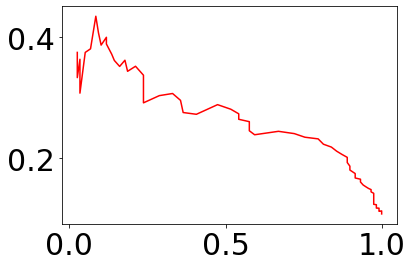

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font size
mpl.rcParams['font.size'] = 30

def plot_precision_recall_using_SNVs(df): 
  zscore_thresholds = np.arange(-4, 5.5, 0.1) 
  precision_recall = [
    compute_precision_recall_using_SNVs(df, zscore_threshold, log=True)
    for zscore_threshold in zscore_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(recalls, precisions, label='using SNVs', color='red')

plot_precision_recall_using_SNVs(LABELED_EXAMPLES)

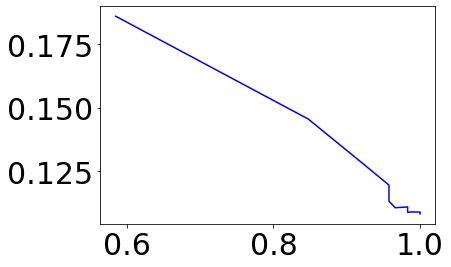

In [12]:
def plot_precision_recall_using_SVs(df): 
  deletion_count_thresholds = np.arange(0, 11, 1)
  precision_recall = [
    compute_precision_recall_using_SVs(df, deletion_count_threshold, log=False)
    for deletion_count_threshold in deletion_count_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(recalls, precisions, label='using SVs', color='blue')

plot_precision_recall_using_SVs(LABELED_EXAMPLES)

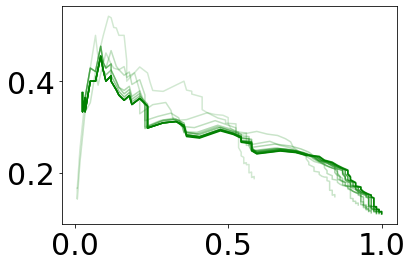

In [13]:
def plot_precision_recall_using_voting_ensemble(df): 
  zscore_thresholds = np.arange(-4, 5.5, 0.1) 
  deletion_count_thresholds = np.arange(0, 11, 1)
  alphas = np.logspace(-0.75, 0, len(deletion_count_thresholds))
  for index, (alpha, deletion_count_threshold) in enumerate(zip(alphas, deletion_count_thresholds)):
    precision_recall = [
      compute_precision_recall_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold, log=False)
      for zscore_threshold in zscore_thresholds
    ]
    precisions, recalls = zip(*precision_recall)
    if index == 0 or index == len(deletion_count_thresholds) - 1: 
      plt.plot(recalls, precisions, label=f'using SNVs and SVs (majority-vote ensemble)\n(deletion-count threshold = {deletion_count_thresholds[index]})', color='green', alpha=alpha)
    else:
      plt.plot(recalls, precisions, color='green', alpha=alpha)

plot_precision_recall_using_voting_ensemble(LABELED_EXAMPLES)

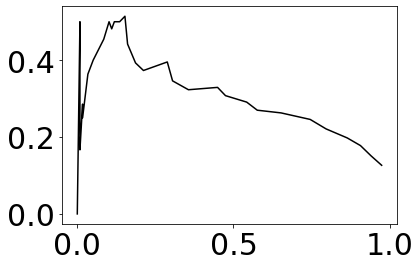

In [15]:
def plot_precision_recall_using_probabilistic_model(df, prob_thresholds): 
  precision_recall = [
    compute_precision_recall_using_probabilistic_model(df, prob_threshold, log=False)
    for prob_threshold in prob_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(recalls, precisions, label='using SNVs and SVs (probabilistic model)', color='black')

plot_precision_recall_using_probabilistic_model(
  LABELED_EXAMPLES, 
  prob_thresholds=np.arange(0.02, 0.8, 0.02) 
)

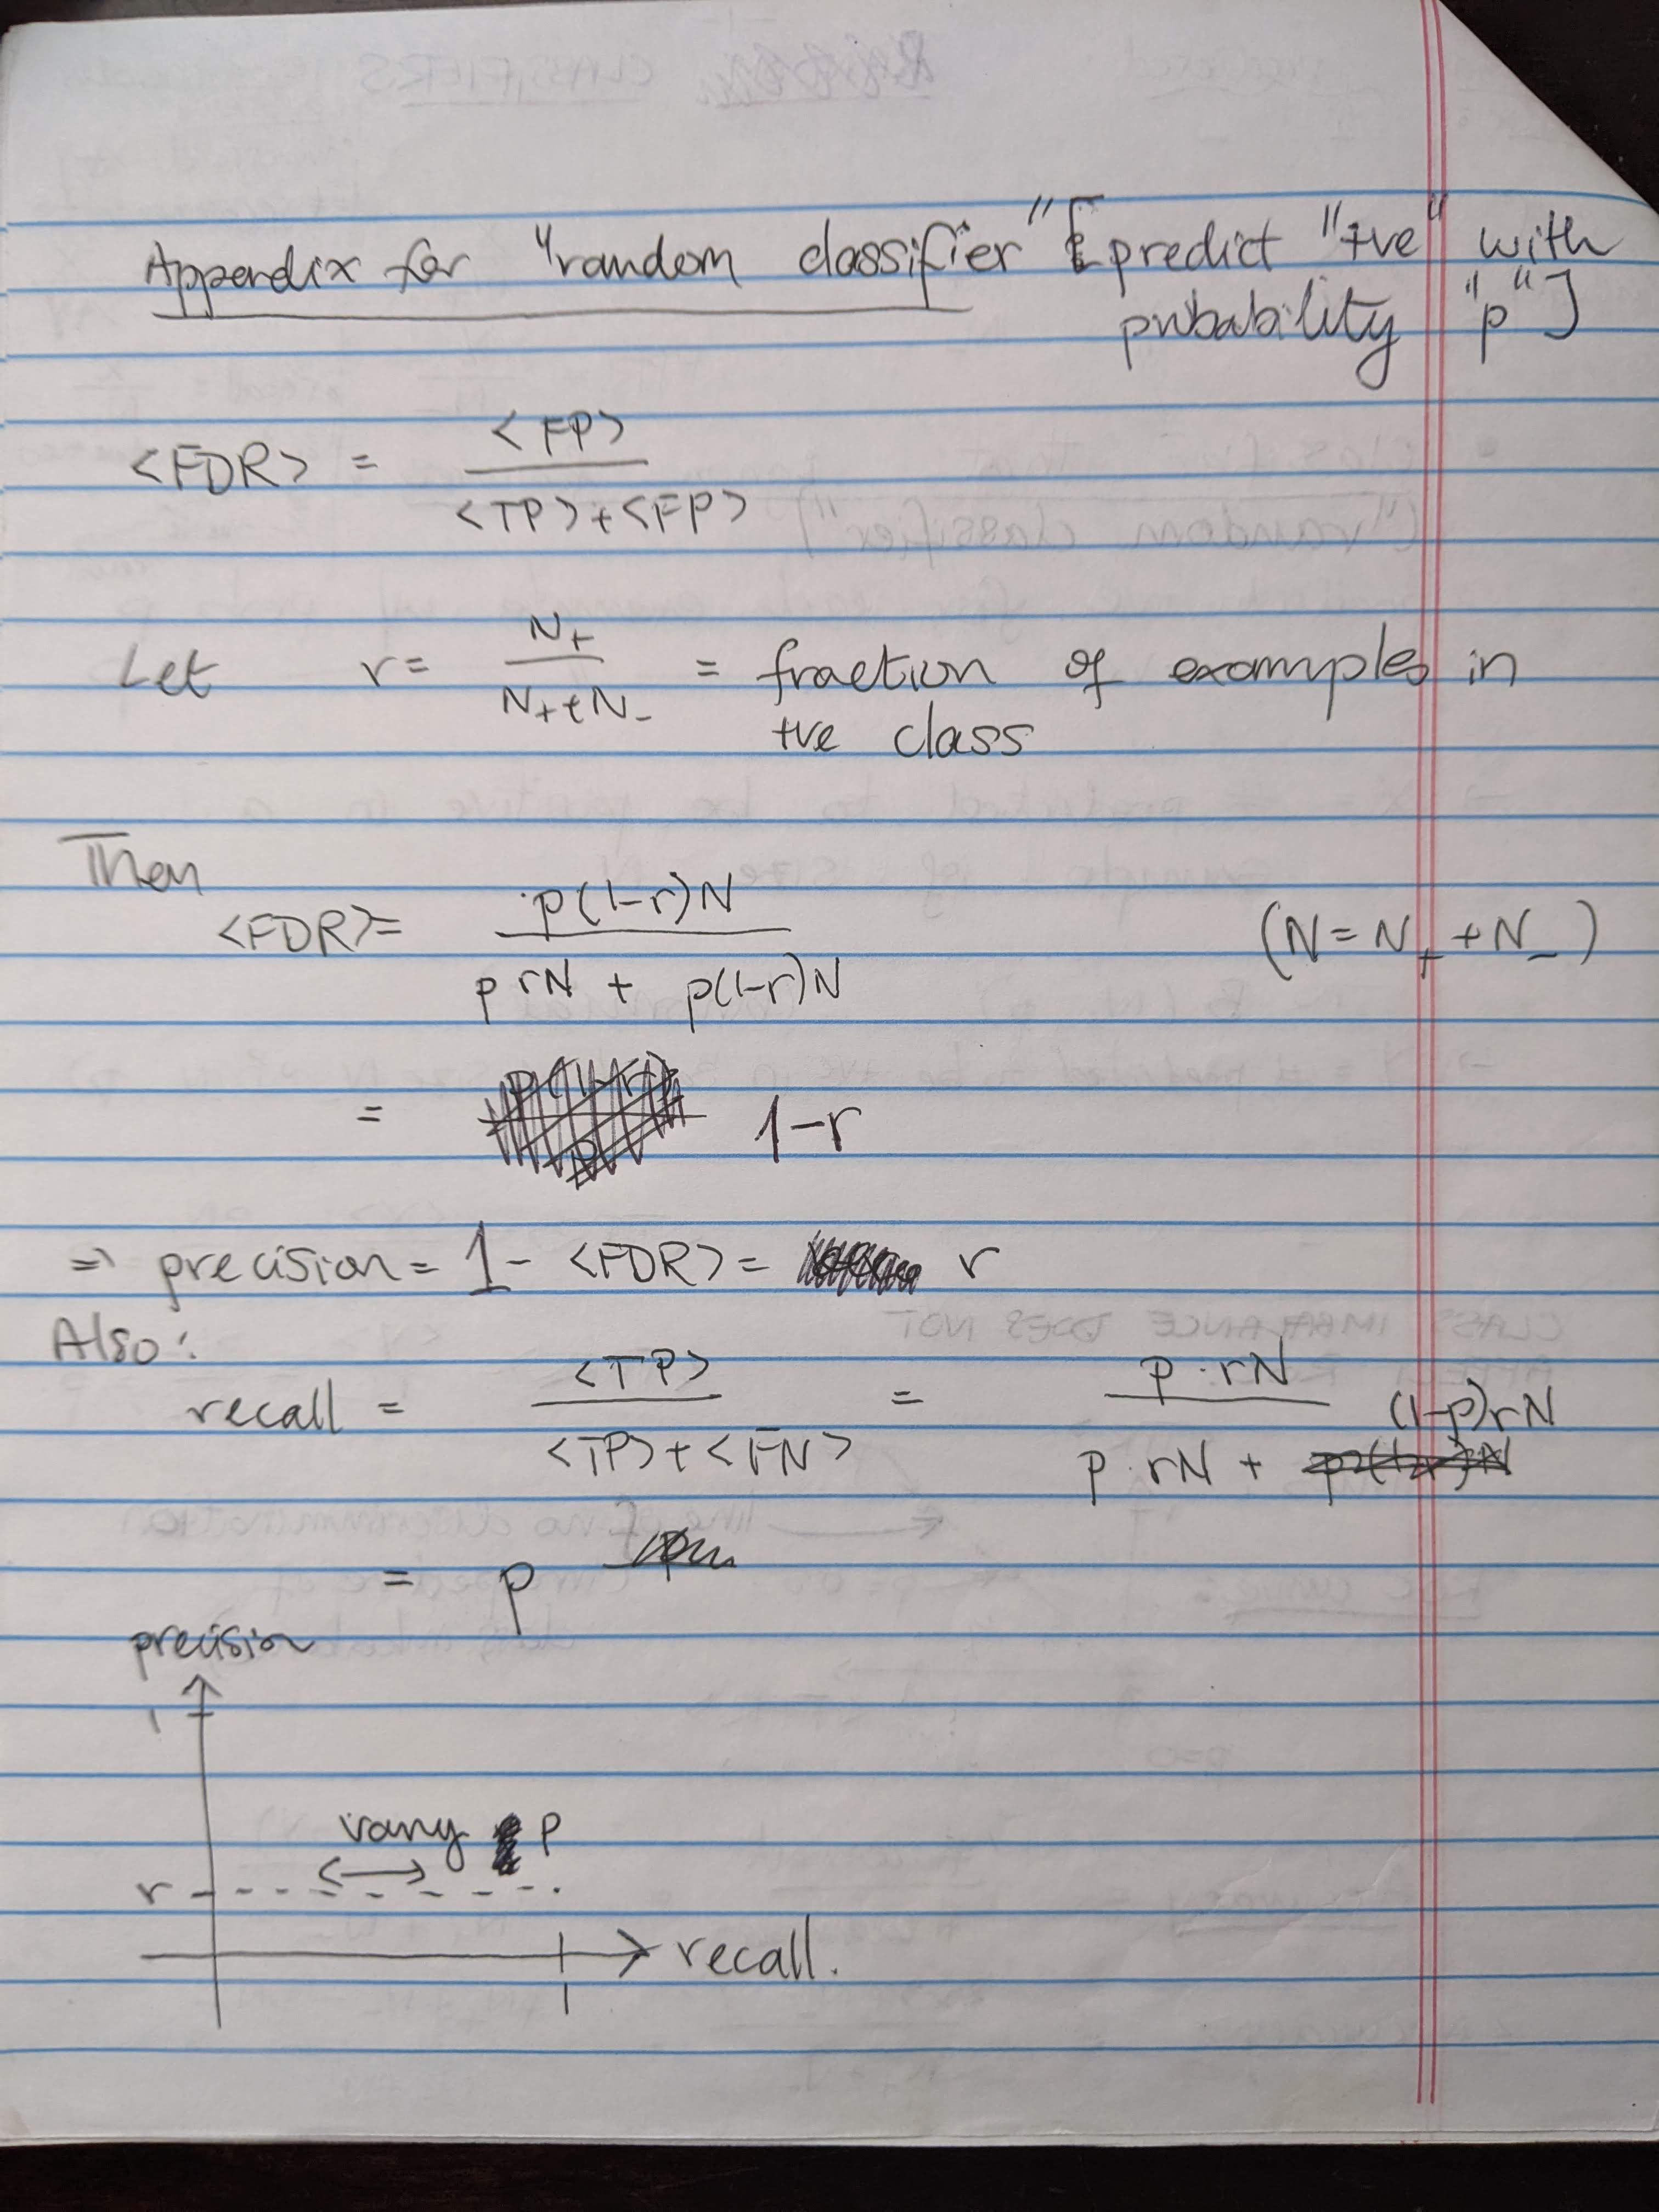

In [17]:
from IPython.display import Image
Image(filename='precision_recall_random_classifier.jpg', width=600)

In [18]:
def compute_positive_fraction(df):
  # this is "r" in the above figure
  number_negative_examples = df['truly constrained'].value_counts().loc[False]
  number_positive_examples = df['truly constrained'].value_counts().loc[True]
  return number_positive_examples / (number_negative_examples + number_positive_examples)

compute_positive_fraction(LABELED_EXAMPLES)

0.10554561717352415

-4.0
truly constrained            False  True
predicted to be constrained             
False                          995   115
True                             5     3
-3.9
truly constrained            False  True
predicted to be constrained             
False                          994   115
True                             6     3
-3.8
truly constrained            False  True
predicted to be constrained             
False                          993   114
True                             7     4
-3.6999999999999997
truly constrained            False  True
predicted to be constrained             
False                          991   114
True                             9     4
-3.5999999999999996
truly constrained            False  True
predicted to be constrained             
False                          990   112
True                            10     6
-3.4999999999999996
truly constrained            False  True
predicted to be constrained             
False                  

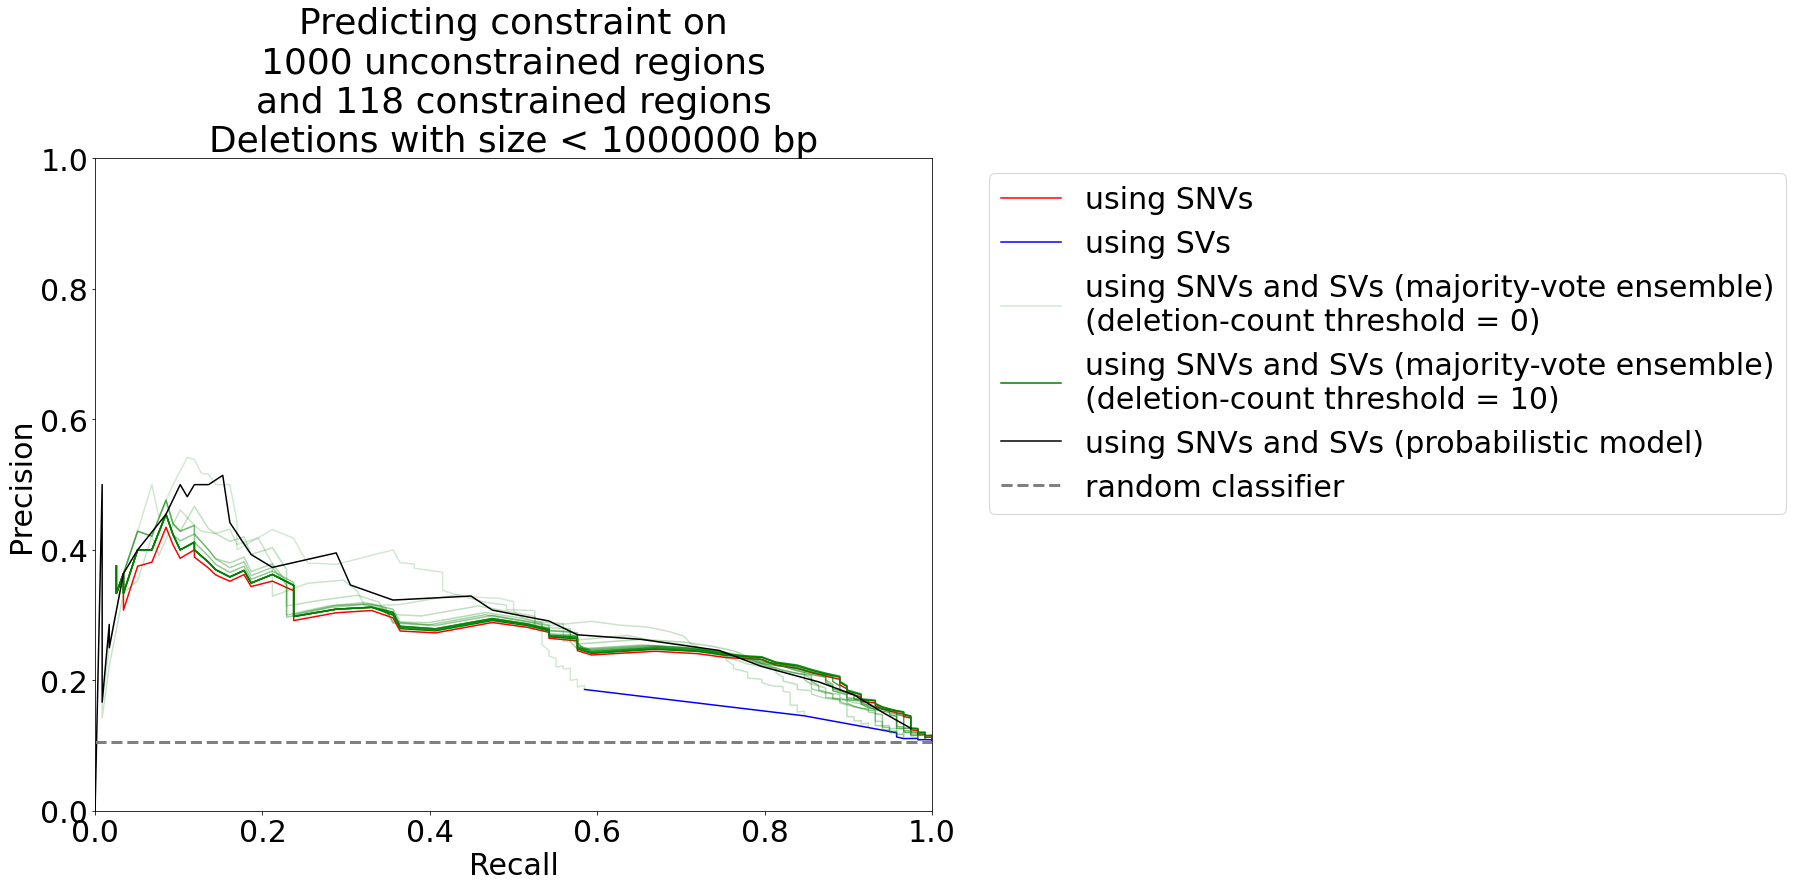

In [19]:
def plot_precision_recall_wrapper(df, prob_thresholds): 
  plot_precision_recall_using_SNVs(df)
  plot_precision_recall_using_SVs(df)
  plot_precision_recall_using_voting_ensemble(df)
  plot_precision_recall_using_probabilistic_model(df, prob_thresholds)  

  r = compute_positive_fraction(df)
  plt.plot([0, 1], [r, r], linestyle='--', linewidth=3, color='grey', label='random classifier')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  fig = plt.gcf()
  fig.set_size_inches(15, 12)
  plt.xlim(0, 1)
  plt.ylim(0, 1)

  number_unconstrained_regions = df['truly constrained'].value_counts().loc[False]
  number_constrained_regions = df['truly constrained'].value_counts().loc[True]
  plt.title(
    'Predicting constraint on\n'
    f'{number_unconstrained_regions} unconstrained regions\n'
    f'and {number_constrained_regions} constrained regions\n'
    f'Deletions with size < {DELETION_SIZE_THRESHOLD} bp'
  )
  
plot_precision_recall_wrapper(LABELED_EXAMPLES, prob_thresholds=np.arange(0.02, 0.8, 0.02))